In [10]:
import torch
import shlex
import argparse
parser = argparse.ArgumentParser(description="Training script")
parser.add_argument('--fold', type=int, required=True, help='Fold number for cross-validation')
parser.add_argument('--gpu', type=str, default="0", help='GPU id to use')
parser.add_argument('--refine_mode', type=str, default="residual", help='Refine mode', choices=["residual", "direct"])
parser.add_argument('--noise_level', type=float, default=1, help='Noise level') 
parser.add_argument('--steps', type=int, default=25000, help='Number of steps to train')
parser.add_argument('--learning_rate', type=float, default=1e-5, help='Learning rate') 
parser.add_argument('--weight_decay', type=float, default=1e-2, help='Weight decay')
parser.add_argument('--mask_upsample', type=str, default="interpolate", help='Mask upsample method', choices=["interpolate", "transpose_conv", "shuffle"])
parser.add_argument('--refine_see_bg', action="store_true", help='If refine operator can see background')
parser.add_argument('--backbone', type=str, default="4", help='Backbone size to use', choices=["0", "1", "2", "3", "4"])
argString = '--gpu 0 --fold 2 --noise_level 0.3 --steps 50000 --learning_rate 4e-5 --mask_upsample shuffle --weight_decay 3e-2'
args = parser.parse_args(shlex.split(argString))

In [11]:
from conv3d_with_refine import MyModel
net = MyModel(args)
net.load_state_dict(torch.load("backup1.pth"))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized: ['segformer.encoder.test.bias', 'segformer.encoder.test.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3240966/1339156479.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

<All keys matched successfully>

In [12]:
from video_dataloader import CustomDataset
val_dataset = CustomDataset("/home/wg25r/fastdata/CDNet", "/home/wg25r/fastdata/CDNet", args.fold, "val")

In [ ]:
import tqdm
import cv2
import torch


fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('inf.mp4', fourcc, 10, (3 * 512, 512))  # Assuming frames are 256x256
net = net.cuda()

def un_standardize(X):
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return X * std + mean


for i in tqdm.tqdm(range(0, len(val_dataset), 1)):
    X, Y, ROI = val_dataset[i]
    
    X_tensor = X.float().unsqueeze(0).cuda()
    ROI = ROI.cuda()
    with torch.no_grad():
        pred = net(X_tensor)
    
    pred_np = (pred.squeeze() * ROI).cpu().numpy()[-1]
    Y_np = Y.squeeze().cpu().numpy()
    X_np = un_standardize(X[:3]).squeeze().permute(1, 2, 0).numpy()
    
    pred_bgr = cv2.cvtColor(pred_np, cv2.COLOR_GRAY2BGR)
    Y_bgr = cv2.cvtColor(Y_np, cv2.COLOR_GRAY2BGR)
    
    combined = cv2.hconcat([pred_bgr, Y_bgr, X_np])
    combined = combined * 255
    combined = combined.astype("uint8")
    out.write(combined)

out.release()

100%|██████████| 1024/1024 [07:13<00:00,  2.36it/s]


: 

In [17]:
Y_bgr.shape

(512, 512, 3)

In [5]:
with open("/mnt/fastdata/CDNet/val_4.txt", "r") as f:
    filenames = f.read().split("\n")

/home/wg25r/remeow/./DIS/IS-Net/models/isnet.py:77: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


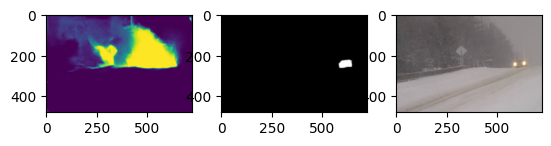

In [6]:
import tqdm
import numpy as np
import random
import cv2

idx = 70
sub_set = random.sample(filenames, 4000)
in0 = cv2.cvtColor(cv2.imread("/mnt/fastdata/CDNet/in/"+sub_set[idx]), cv2.COLOR_BGR2RGB)
long0 = cv2.cvtColor(cv2.imread("/mnt/fastdata/CDNet/long/"+sub_set[idx]), cv2.COLOR_BGR2RGB)
short0 = cv2.cvtColor(cv2.imread("/mnt/fastdata/CDNet/short/"+sub_set[idx]), cv2.COLOR_BGR2RGB)

in0 = torch.from_numpy(in0).float().permute(2, 0, 1)
long0 = torch.from_numpy(long0).float().permute(2, 0, 1)
short0 = torch.from_numpy(short0).float().permute(2, 0, 1)
img0 = torch.cat([in0, long0, short0], 0).unsqueeze(0).cuda()
res = torch.nn.functional.interpolate(net(img0), size=(in0.shape[1], in0.shape[2]), mode='bilinear', align_corners=False)
import pylab
gt = cv2.cvtColor(cv2.imread("/mnt/fastdata/CDNet/gt/"+sub_set[idx]), cv2.COLOR_BGR2RGB)

pylab.subplot(1, 3, 1)
pylab.imshow(res[0, 0].cpu().detach().numpy())
pylab.subplot(1, 3, 2)
pylab.imshow(gt) 
pylab.subplot(1, 3, 3)
pylab.imshow(in0.permute(1, 2, 0).cpu().detach().numpy()/255)